# Notebook for producing spectral density plots

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


## Re-train models and compute spectral information

### Convection

- $u_t + \beta u_x = 0$ on $x \in [0, 2\pi], \, t \in [0,1]$ with initial condition $u(x,0) = \sin(x)$ and periodic boundary condition $u(0,t) = u(2\pi,t)$.

- W&B run: [proud-blaze-272](https://wandb.ai/sketchy-opts/convection_adam_lbfgs_final_11k/runs/1b8bka0m/)

- final loss: 0.00000595132314629154
- test l2rs: 0.004193487111479044

- command: `--seed 345 --pde convection --pde_params beta 40 --opt adam_lbfgs --opt_params switch_epochs 11000 adam_lr 0.0001 lbfgs_history_size 100 --num_layers 4 --num_neurons 200 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 12500 --wandb_project convection_adam_lbfgs_final_10k --device 4`

### Reaction

- $u_t - \rho u(1-u) = 0$ on $x \in [0, 2\pi], \, t \in [0,1]$ with initial condition $u(x,0) = \exp(-(x-\pi)^2/(2(\pi/4)^2))$ and periodic boundary condition $u(0,t) = u(2\pi,t)$.

- W&B run: [radiant-sponge-73](https://wandb.ai/sketchy-opts/reaction_adam_lbfgs_final_11k/runs/jzyxz0lf/)

- final loss: 0.0000065193335103686
- test l2rs: 0.029103083536028865

- command: `--seed 456 --pde reaction --pde_params rho 5 --opt adam_lbfgs --opt_params switch_epochs 11000 adam_lr 0.001 lbfgs_history_size 100 --num_layers 4 --num_neurons 200 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 12500 --wandb_project reaction_adam_lbfgs_final_11k --device 5`

### Wave

- $u_{tt} - 4 u_{xx} = 0$ on $x \in [0, 1], \, t \in [0,1]$ with initial condition $u(x,0) = \sin(\pi x) + (1/2)\sin(\beta \pi x)$, $u_t(x,0) = 0$ and periodic boundary condition $u(0,t) = u(1,t)$.

W&B run: [firm-firefly-475](https://wandb.ai/sketchy-opts/wave_adam_lbfgs_final_11k/runs/n5mv617c/)

- final loss: 0.0015578616876155138
- test l2rs: 0.07878360897302628

- command: `--seed 567 --pde wave --pde_params beta 5 --opt adam_lbfgs --opt_params switch_epochs 11000 adam_lr 0.001 lbfgs_history_size 100 --num_layers 4 --num_neurons 200 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 12500 --wandb_project wave_adam_lbfgs_final_10k --device 6`

In [ ]:
from src.models import PINN
from src.train_utils import *
from src.opts.adam_lbfgs import Adam_LBFGS
from src.pyhessian import hessian
from src.precond_hessian import precond_hessian
from tqdm import tqdm

In [ ]:
def compute_spectral_info(initial_seed, pde_name, pde_params, opt_name, switch_epochs, adam_lr, lbfgs_history_size, num_layers, num_neurons, loss_name, num_x, num_t, num_res, num_epochs, device):
  # initializations
  set_random_seed(initial_seed)

  model = PINN(in_dim=2, hidden_dim=num_neurons, out_dim=1, num_layer=num_layers).to(device)
  model.apply(init_weights)

  x_range, t_range, loss_func, pde_coefs = get_pde(pde_name, pde_params, loss_name)
  opt_params_list = ["switch_epochs", str(switch_epochs), "adam_lr", str(adam_lr), "lbfgs_history_size", str(lbfgs_history_size)]
  opt_params = get_opt_params(opt_params_list)
  opt = get_opt(opt_name, opt_params, model.parameters())
  x, t, data_params = get_data(x_range, t_range, num_x, num_t, random=True, num_res_samples=num_res, device=device)

  loss_hist = []
  loss_res_hist = []
  loss_bc_hist = []
  loss_ic_hist = []
  grad_norm_hist = []

  loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
  loss = loss_res + loss_bc + loss_ic

  loss_hist.append(loss.item())
  loss_res_hist.append(loss_res.item())
  loss_bc_hist.append(loss_bc.item())
  loss_ic_hist.append(loss_ic.item())

  for i in (progress_bar:=tqdm(range(num_epochs), ncols=125)):
    # training
    model.train()
    def closure():
      opt.zero_grad()
      outputs = predict(x, t, model)
      loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
      loss = loss_res + loss_bc + loss_ic
      loss.backward()

      return loss

    opt.step(closure)

    # evaluation
    model.eval()

    with torch.no_grad():
      for p in model.parameters():
        if p.grad is not None:
          p.grad = None

    loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
    loss = loss_res + loss_bc + loss_ic
    loss.backward()

    grad_norm = 0
    for p in model.parameters():
      grad_norm += p.grad.norm().item() ** 2
    grad_norm = grad_norm ** 0.5

    loss_hist.append(loss.item())
    loss_res_hist.append(loss_res.item())
    loss_bc_hist.append(loss_bc.item())
    loss_ic_hist.append(loss_ic.item())
    grad_norm_hist.append(grad_norm)

    progress_bar.set_postfix_str("res {:.2e} / bc {:.2e} / ic {:.2e} / grad_norm {:.2e}".format(loss_res_hist[-1], loss_bc_hist[-1], loss_ic_hist[-1], grad_norm))

  # testing
  x_test, t_test, data_params_test = get_data(x_range, t_range, int((num_x - 1) / 2) + 1, num_t, random=False, device=device)
  with torch.no_grad():
    predictions = torch.vstack(predict(x_test, t_test, model)).cpu().detach().numpy()
  targets = get_ref_solutions(pde_name, pde_coefs, x_test, t_test, data_params_test)
  test_l1re = l1_relative_error(predictions, targets)
  test_l2re = l2_relative_error(predictions, targets)

  print("final loss {:.2e} / test l2rs {:.2e}".format(loss_hist[-1], test_l2re))

  # compute spectral information
  # total loss
  hessian_comp = hessian(model, predict, loss_func, data=(x,t), device=device)
  hessian_eig, hessian_weight = hessian_comp.density(num_run=10)
  precond_hessian_comp = precond_hessian(model, predict, loss_func, opt.lbfgs, data=(x,t), device=device)
  precond_hessian_eig, precond_hessian_weight = precond_hessian_comp.density(num_run=10)

  # residual
  hessian_comp_res = hessian(model, predict, loss_func, data=(x,t), loss_comp='res', device=device)
  hessian_eig_res, hessian_weight_res = hessian_comp_res.density(num_run=10)
  precond_hessian_comp_res = precond_hessian(model, predict, loss_func, opt.lbfgs, data=(x,t), loss_comp='res', device=device)
  precond_hessian_eig_res, precond_hessian_weight_res = precond_hessian_comp_res.density(num_run=10)

  # initial
  hessian_comp_ic = hessian(model, predict, loss_func, data=(x,t), loss_comp='ic', device=device)
  hessian_eig_ic, hessian_weight_ic = hessian_comp_ic.density(num_run=10)
  precond_hessian_comp_ic = precond_hessian(model, predict, loss_func, opt.lbfgs, data=(x,t), loss_comp='ic', device=device)
  precond_hessian_eig_ic, precond_hessian_weight_ic = precond_hessian_comp_ic.density(num_run=10)

  # boundary
  hessian_comp_bc = hessian(model, predict, loss_func, data=(x,t), loss_comp='bc', device=device)
  hessian_eig_bc, hessian_weight_bc = hessian_comp_bc.density(num_run=10)
  precond_hessian_comp_bc = precond_hessian(model, predict, loss_func, opt.lbfgs, data=(x,t), loss_comp='bc', device=device)
  precond_hessian_eig_bc, precond_hessian_weight_bc = precond_hessian_comp_bc.density(num_run=10)

  # save the results
  torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'adam_state_dict': opt.adam.state_dict(),
            'lbfgs_state_dict': opt.lbfgs.state_dict(),
            'loss_hist': loss_hist,
            'loss_res_hist': loss_res_hist,
            'loss_bc_hist': loss_bc_hist,
            'loss_ic_hist': loss_ic_hist,
            'grad_norm_hist': grad_norm_hist,
            'hessian_eig': hessian_eig,
            'hessian_weight': hessian_weight,
            'precond_hessian_eig': precond_hessian_eig,
            'precond_hessian_weight': precond_hessian_weight,
            'hessian_eig_res': hessian_eig_res,
            'hessian_weight_res': hessian_weight_res,
            'precond_hessian_eig_res': precond_hessian_eig_res,
            'precond_hessian_weight_res': precond_hessian_weight_res,
            'hessian_eig_ic': hessian_eig_ic,
            'hessian_weight_ic': hessian_weight_ic,
            'precond_hessian_eig_ic': precond_hessian_eig_ic,
            'precond_hessian_weight_ic': precond_hessian_weight_ic,
            'hessian_eig_bc': hessian_eig_bc,
            'hessian_weight_bc': hessian_weight_bc,
            'precond_hessian_eig_bc': precond_hessian_eig_bc,
            'precond_hessian_weight_bc': precond_hessian_weight_bc
            }, 'spectral_' + pde_name)

In [ ]:
run_specs = [
  {'initial_seed': 345,
   'pde_name': "convection",
   'pde_params': ["beta", "40"],
   'opt_name': "adam_lbfgs",
   'switch_epochs': 11000,
   'adam_lr': 0.0001,
   'lbfgs_history_size': 100,
   'num_layers': 4,
   'num_neurons': 200,
   'loss_name': "mse",
   'num_x': 257,
   'num_t': 101,
   'num_res': 10000,
   'num_epochs': 12500
  },
  {'initial_seed': 456,
   'pde_name': "reaction",
   'pde_params': ["rho", "5"],
   'opt_name': "adam_lbfgs",
   'switch_epochs': 11000,
   'adam_lr': 0.001,
   'lbfgs_history_size': 100,
   'num_layers': 4,
   'num_neurons': 200,
   'loss_name': "mse",
   'num_x': 257,
   'num_t': 101,
   'num_res': 10000,
   'num_epochs': 12500
  },
  {'initial_seed': 567,
   'pde_name': "wave",
   'pde_params': ["beta", "5"],
   'opt_name': "adam_lbfgs",
   'switch_epochs': 11000,
   'adam_lr': 0.001,
   'lbfgs_history_size': 100,
   'num_layers': 4,
   'num_neurons': 200,
   'loss_name': "mse",
   'num_x': 257,
   'num_t': 101,
   'num_res': 10000,
   'num_epochs': 12500
  }
]
device = "cuda:2"
for run in run_specs:
  initial_seed = run['initial_seed']
  pde_name = run['pde_name']
  pde_params = run['pde_params']
  opt_name = run['opt_name']
  switch_epochs = run['switch_epochs']
  adam_lr = run['adam_lr']
  lbfgs_history_size = run['lbfgs_history_size']
  num_layers = run['num_layers']
  num_neurons = run['num_neurons']
  loss_name = run['loss_name']
  num_x = run['num_x']
  num_t = run['num_t']
  num_res = run['num_res']
  num_epochs = run['num_epochs']
  compute_spectral_info(initial_seed=initial_seed, pde_name=pde_name, pde_params=pde_params, opt_name=opt_name, switch_epochs=switch_epochs, adam_lr=adam_lr, lbfgs_history_size=lbfgs_history_size, num_layers=num_layers, num_neurons=num_neurons, loss_name=loss_name, num_x=num_x, num_t=num_t, num_res=num_res, num_epochs=num_epochs, device=device)

## Define the density approximation function

The implementation is adapted from `eigv_to_density()` of the original code for the paper [An Investigation into Neural Net Optimization via Hessian Eigenvalue Density](https://arxiv.org/abs/1901.10159) (ICML 2019) by Ghorbani, Krishnan, and Xiao.

In [ ]:
"""
INPUT:
- eigenvalues: eigenvalues from each run
- weights: corresponding eigenvalue weights from each run
- num_grid_points: number of points on the grid
- sigma_squared: smoothing variable (in the range of [1e-5,1e-1])
- boundary_margin: additional margin on both sides of the grid
OUTPUT:
- densities: density at each grid point
- grid_points: grid points
"""
def generate_density(eigenvalues, weights, num_grid_points=int(1e5), sigma_squared=1e-5, boundary_margin=1e-3):

  def gaussian(x, x0, variance):
    return np.exp(-(x0 - x)**2 / (2.0 * variance)) / np.sqrt(2 * np.pi * variance)

  eigenvalues = np.array(eigenvalues).real
  weights = np.array(weights).real

  num_runs, num_eigvals = eigenvalues.shape

  lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + boundary_margin
  lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - boundary_margin

  grid_points = np.linspace(lambda_min, lambda_max, num=num_grid_points)
  grid_length = (lambda_max - lambda_min) / (num_grid_points - 1)

  sigma = sigma_squared * max(1, (lambda_max - lambda_min))

  # compute density
  densities = np.zeros((num_runs, num_grid_points), dtype=eigenvalues.dtype)
  for i in range(num_runs):
    for j in range(num_grid_points):
      x = grid_points[j]
      convolutions = gaussian(eigenvalues[i,:], x, sigma)
      densities[i,j] = np.sum(convolutions * weights[i,:])

  # average across runs
  densities = np.mean(densities, axis=0)
  densities = densities / (np.sum(densities) * grid_length)

  return densities, grid_points

## Making plots

We plot the best runs (in terms of L2 relative error) for each PDE problem in its "hardest setting".

- Convection: [proud-blaze-272](https://wandb.ai/sketchy-opts/convection_adam_lbfgs_final_11k/runs/1b8bka0m/) with final test l2rs 0.004193487111479044
- Reaction: [radiant-sponge-73](https://wandb.ai/sketchy-opts/reaction_adam_lbfgs_final_11k/runs/jzyxz0lf/) with final test l2rs 0.029103083536028865
- Wave: [firm-firefly-475](https://wandb.ai/sketchy-opts/wave_adam_lbfgs_final_11k/runs/n5mv617c/) with final test l2rs 0.07878360897302628

In [ ]:
def get_title(pde_name, pde_params):
  if pde_name == "convection":
    return f'Convection, $\\beta = {pde_params[1]}$'
  elif pde_name == "reaction":
    return f'Reaction, $\\rho = {pde_params[1]}$'
  elif pde_name == "wave":
    return f'Wave, $\\beta = {pde_params[1]}$'

In [ ]:
# load saved results
pdes = [('convection', ['beta', '40']), ('reaction', ['rho', '5']), ('wave', ['beta', '5'])]
saved_results = {}
for pde_name, _ in pdes:
  saved_results[pde_name] = torch.load('spectral_' + pde_name, map_location=torch.device('cpu'))

# make sure texts are rendered in serif via LaTex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [ ]:
# compute approximated densities for total loss
def plot_spectral_density_multi_pde(pdes, saved_results, line_colors, line_styles, font_size, gaussian_variance, y_cutoff, folder_path, filename):
  mpl.rcParams.update({'font.size': font_size})

  nrows = 1
  ncols = len(pdes)

  fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))

  legend_elements = [
    plt.Line2D([0], [0], color=line_colors['hessian'], linestyle=line_styles['hessian'], label='Hessian'),
    plt.Line2D([0], [0], color=line_colors['precond_hessian'], linestyle=line_styles['precond_hessian'], label='Preconditioned Hessian')
  ]

  for col, (pde_name, pde_params) in enumerate(pdes):
    pde_result = saved_results[pde_name]

    hessian_densities, hessian_grid = generate_density(pde_result['hessian_eig'], pde_result['hessian_weight'], sigma_squared=gaussian_variance)
    precond_hessian_densities, precond_hessian_grid = generate_density(pde_result['precond_hessian_eig'], pde_result['precond_hessian_weight'], sigma_squared=gaussian_variance)

    # identify first and last grid points such that the corresponding density is no smaller than the cutoff
    xlim_idx_hessian = np.argwhere(hessian_densities >= y_cutoff)[[0, -1]]
    xlim_idx_precond_hessian = np.argwhere(precond_hessian_densities >= y_cutoff)[[0, -1]]
    # pick the overall boundary grid points
    xlim_lower = min(hessian_grid[xlim_idx_hessian[0]], precond_hessian_grid[xlim_idx_precond_hessian[0]])
    xlim_upper = max(hessian_grid[xlim_idx_hessian[1]], precond_hessian_grid[xlim_idx_precond_hessian[1]])
    # for the lower boundary, we round it down to the nearest power of 10
    lower_exponent = np.floor(np.log10(np.abs(xlim_lower)))
    xlim_lower = -1 * (10 ** (lower_exponent + 1)) if xlim_lower < 0 else 10 ** lower_exponent
    if (xlim_lower <= 0) & (xlim_lower > -0.5):
      xlim_lower = -0.5 # make sure the there is space if it's negative and too close to zero
    # for the upper boundary, we round it up to the nearest integer significand
    upper_exponent = np.floor(np.log10(np.abs(xlim_upper)))
    xlim_upper = np.ceil(xlim_upper / (10 ** upper_exponent)) * (10 ** upper_exponent)

    ax = axs[col]
    ax.semilogy(hessian_grid, hessian_densities, color=line_colors['hessian'], linestyle=line_styles['hessian'])
    ax.semilogy(precond_hessian_grid, precond_hessian_densities, color=line_colors['precond_hessian'], linestyle=line_styles['precond_hessian'])
    ax.set_xscale('symlog')
    ax.set_ylim(bottom=y_cutoff)
    ax.set_xlim(left=xlim_lower, right=xlim_upper)
    ax.set_ylabel('Density')
    ax.set_xlabel('Eigenvalue')
    ax.set_title(get_title(pde_name, pde_params))

  fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

  filename = filename + '.pdf'
  fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
  plt.show()

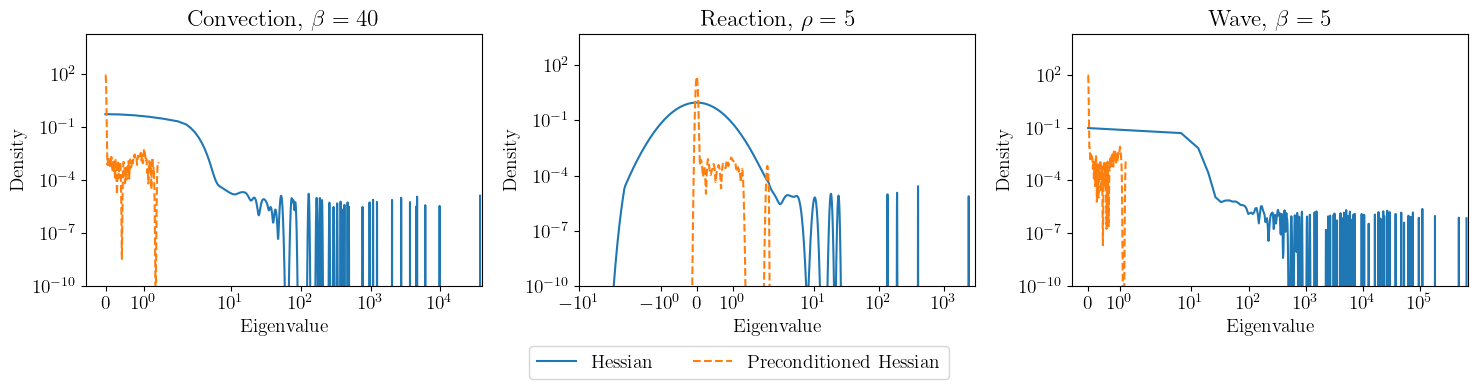

In [ ]:
line_colors = {
  'hessian': 'tab:blue',
  'precond_hessian': 'tab:orange'
}
line_styles = {
  'hessian': 'solid',
  'precond_hessian': 'dashed'
}
plot_spectral_density_multi_pde(pdes, saved_results, line_colors, line_styles, font_size=14, gaussian_variance=5e-5, y_cutoff=1e-10, folder_path='spectral_density_plots', filename='spectral_density_multi_pde')

In [ ]:
# compute approximated densities for each loss component
def plot_spectral_density_loss_component(pde_name, pde_params, pde_result, component_names, line_colors, line_styles, font_size, gaussian_variance, y_cutoff, folder_path, filename):
  mpl.rcParams.update({'font.size': font_size})

  nrows = 1
  ncols = len(component_names)

  fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))

  legend_elements = [
    plt.Line2D([0], [0], color=line_colors['hessian'], linestyle=line_styles['hessian'], label='Hessian'),
    plt.Line2D([0], [0], color=line_colors['precond_hessian'], linestyle=line_styles['precond_hessian'], label='Preconditioned Hessian')
  ]

  for col, (component, component_name) in enumerate(component_names.items()):
    hessian_densities, hessian_grid = generate_density(pde_result['hessian_eig_' + component], pde_result['hessian_weight_' + component], sigma_squared=gaussian_variance)
    precond_hessian_densities, precond_hessian_grid = generate_density(pde_result['precond_hessian_eig_' + component], pde_result['precond_hessian_weight_' + component], sigma_squared=gaussian_variance)

    # identify first and last grid points such that the corresponding density is no smaller than the cutoff
    xlim_idx_hessian = np.argwhere(hessian_densities >= y_cutoff)[[0, -1]]
    xlim_idx_precond_hessian = np.argwhere(precond_hessian_densities >= y_cutoff)[[0, -1]]
    # pick the overall boundary grid points
    xlim_lower = min(hessian_grid[xlim_idx_hessian[0]], precond_hessian_grid[xlim_idx_precond_hessian[0]])
    xlim_upper = max(hessian_grid[xlim_idx_hessian[1]], precond_hessian_grid[xlim_idx_precond_hessian[1]])
    # for the lower boundary, we round it down to the nearest power of 10
    lower_exponent = np.floor(np.log10(np.abs(xlim_lower)))
    xlim_lower = -1 * (10 ** (lower_exponent + 1)) if xlim_lower < 0 else 10 ** lower_exponent
    if (xlim_lower <= 0) & (xlim_lower > -0.5):
      xlim_lower = -0.5 # make sure the there is space if it's negative and too close to zero
    # for the upper boundary, we round it up to the nearest integer significand
    upper_exponent = np.floor(np.log10(np.abs(xlim_upper)))
    xlim_upper = np.ceil(xlim_upper / (10 ** upper_exponent)) * (10 ** upper_exponent)

    ax = axs[col]
    ax.semilogy(hessian_grid, hessian_densities, color=line_colors['hessian'], linestyle=line_styles['hessian'])
    ax.semilogy(precond_hessian_grid, precond_hessian_densities, color=line_colors['precond_hessian'], linestyle=line_styles['precond_hessian'])
    ax.set_xscale('symlog')
    ax.set_ylim(bottom=y_cutoff)
    ax.set_xlim(left=xlim_lower, right=xlim_upper)
    ax.set_ylabel('Density')
    ax.set_xlabel('Eigenvalue')
    ax.set_title(component_name)

  fig.suptitle(get_title(pde_name, pde_params), y=0.9)
  fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

  filename = filename + '.pdf'
  fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
  plt.show()

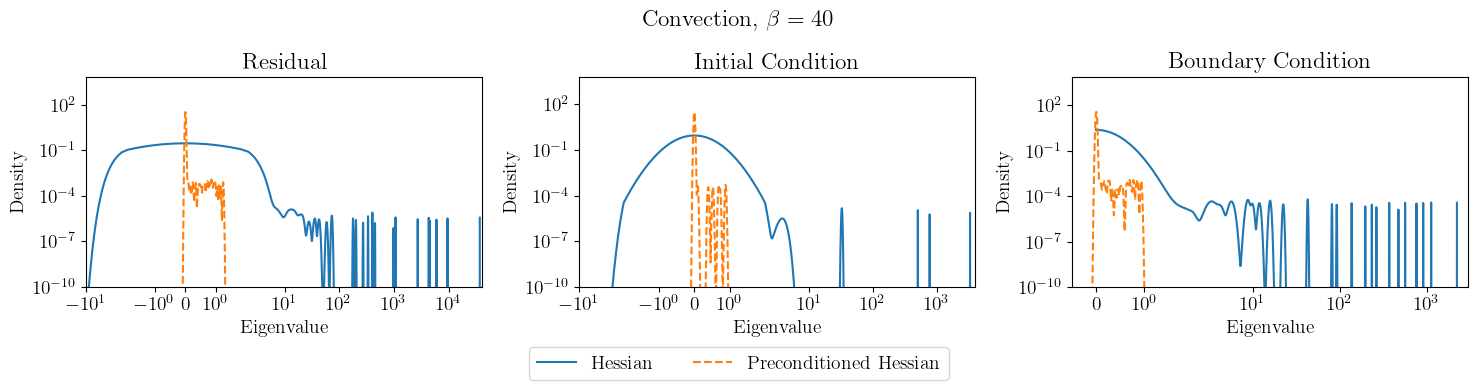

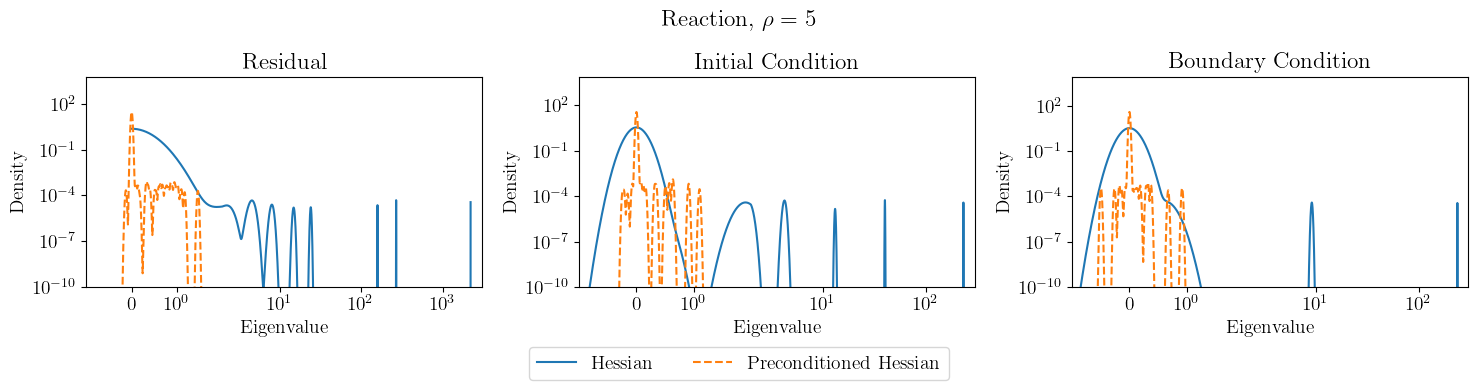

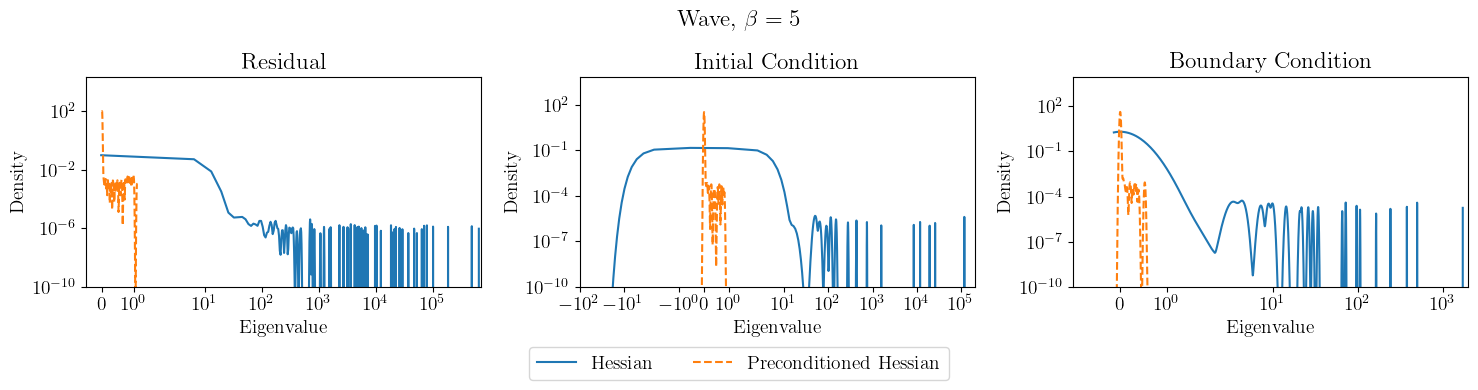

In [ ]:
component_names = {
  'res': 'Residual',
  'ic': 'Initial Condition',
  'bc': 'Boundary Condition'
}
line_colors = {
  'hessian': 'tab:blue',
  'precond_hessian': 'tab:orange'
}
line_styles = {
  'hessian': 'solid',
  'precond_hessian': 'dashed'
}
for pde_name, pde_params in pdes:
  pde_result = saved_results[pde_name]
  plot_spectral_density_loss_component(pde_name, pde_params, pde_result, component_names, line_colors, line_styles, font_size=14, gaussian_variance=5e-5, y_cutoff=1e-10, folder_path='spectral_density_plots', filename='spectral_density_' + pde_name)